# Jenius - Univariate LSTM
Forecasting for Jenius, digital bank in Indonesia

Forecast 5 models the following KPIs, that they'll use for strategic planning
- Balance
- Approved customers
- Funded customers
- New approved customers: shows the number of the new approved customers for each day. Once a customer downloads the bank's application, they need to get through the KYC ("know your customer") process, which means that a representative of a bank should see the customer at least once
- Balance forecast

Additional data sources:
- non-working days (weekends, national holidays)
- paydays
- dates of campaigns

Deliverables:
- models for the 5 KPIs
- fancy visualizations of the predictions
- raw data in Excel format

In [96]:
import math
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import date
import statsmodels.api as sm
from fbprophet import Prophet
from matplotlib import pyplot
from keras.layers import LSTM
from keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn import linear_model
from keras.models import Sequential
import matplotlib.ticker as plticker
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings("ignore")

random.seed(1)

sns.set(rc={'figure.figsize': (18, 6)})

In [2]:
def reduce_memory_usage(df, verbose=True): 
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64'] 
    start_mem = df.memory_usage().sum() / 1024**2 
    if verbose: print('Starting memory usage: {:5.2f} MB'.format(start_mem))

    for col in df.columns: 
        col_type = df[col].dtypes 
        if col_type in numerics: 
            c_min = df[col].min() 
            c_max = df[col].max() 
            if str(col_type)[:3] == 'int': 
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max: 
                    df[col] = df[col].astype(np.int8) 
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max: 
                    df[col] = df[col].astype(np.int16) 
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max: 
                    df[col] = df[col].astype(np.int32) 
                elif c_min >= np.iinfo(np.int64).min and c_max <= np.iinfo(np.int64).max: 
                    df[col] = df[col].astype(np.int64)   
                else: 
                    if c_min >= np.finfo(np.float16).min and c_max <= np.finfo(np.float16).max: 
                        df[col] = df[col].astype(np.float16) 
                    elif c_min >= np.finfo(np.float32).min and c_max <= np.finfo(np.float32).max: 
                        df[col] = df[col].astype(np.float32) 
                    else: 
                        df[col] = df[col].astype(np.float64)     
        end_mem = df.memory_usage().sum() / 1024**2 
        if verbose: print('Reduced memory usage: {:5.2f} MB ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem)) 
        return df

## Exploratory Data Analysis

In [26]:
df_input = pd.read_csv('input/input.csv', sep=';', engine='python')
print("{:,} records and {} features in train set.".format(df_input.shape[0], df_input.shape[1]))

df_input = reduce_memory_usage(df_input)

241 records and 2 features in train set.
Starting memory usage:  0.00 MB
Reduced memory usage:  0.00 MB (0.0% reduction)


In [27]:
pd.options.display.float_format = '{:,.0f}'.format
df_input[:3]

,buss_date,balance
0,2018.06.01,"934,075,825,517"
1,2018.06.02,"929,958,070,324"
2,2018.06.03,"925,557,302,415"


### Univariate LSTM
Inspired by [Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)

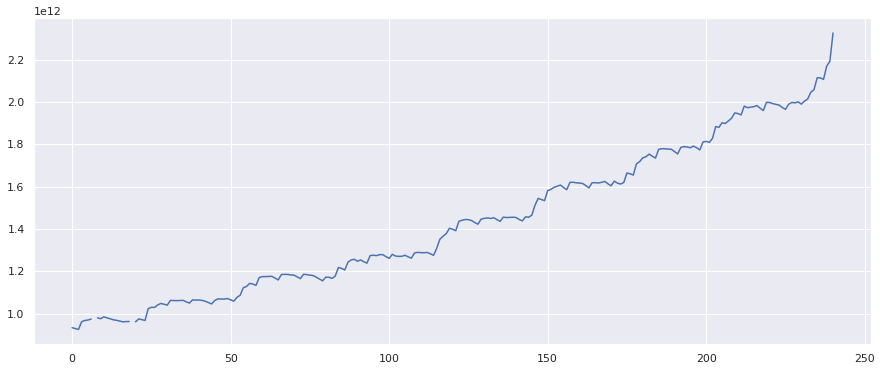

In [28]:
plt.figure(1, figsize=(15, 6))
plt.plot(df_input['balance'])

In [29]:
df_input = df_input.fillna(method='bfill')

dataset = df_input['balance'].values
dataset = dataset.astype('float32')

In [13]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [14]:
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [15]:
len(train), len(test)

(161, 80)

In [16]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [17]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [18]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [19]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2)

Epoch 1/50
 - 1s - loss: 0.0563
Epoch 2/50
 - 0s - loss: 0.0256
Epoch 3/50
 - 0s - loss: 0.0201
Epoch 4/50
 - 0s - loss: 0.0178
Epoch 5/50
 - 0s - loss: 0.0157
Epoch 6/50
 - 0s - loss: 0.0134
Epoch 7/50
 - 0s - loss: 0.0110
Epoch 8/50
 - 0s - loss: 0.0085
Epoch 9/50
 - 0s - loss: 0.0061
Epoch 10/50
 - 0s - loss: 0.0039
Epoch 11/50
 - 0s - loss: 0.0023
Epoch 12/50
 - 0s - loss: 0.0011
Epoch 13/50
 - 0s - loss: 5.3132e-04
Epoch 14/50
 - 0s - loss: 2.5393e-04
Epoch 15/50
 - 0s - loss: 1.5357e-04
Epoch 16/50
 - 0s - loss: 1.1849e-04
Epoch 17/50
 - 0s - loss: 1.1181e-04
Epoch 18/50
 - 0s - loss: 1.1077e-04
Epoch 19/50
 - 0s - loss: 1.1213e-04
Epoch 20/50
 - 0s - loss: 1.1009e-04
Epoch 21/50
 - 0s - loss: 1.0945e-04
Epoch 22/50
 - 0s - loss: 1.0802e-04
Epoch 23/50
 - 0s - loss: 1.0876e-04
Epoch 24/50
 - 0s - loss: 1.1068e-04
Epoch 25/50
 - 0s - loss: 1.1112e-04
Epoch 26/50
 - 0s - loss: 1.1043e-04
Epoch 27/50
 - 0s - loss: 1.0979e-04
Epoch 28/50
 - 0s - loss: 1.0974e-04
Epoch 29/50
 - 0s - l

In [20]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 14536805633.42 RMSE
Test Score: 63559005476.00 RMSE


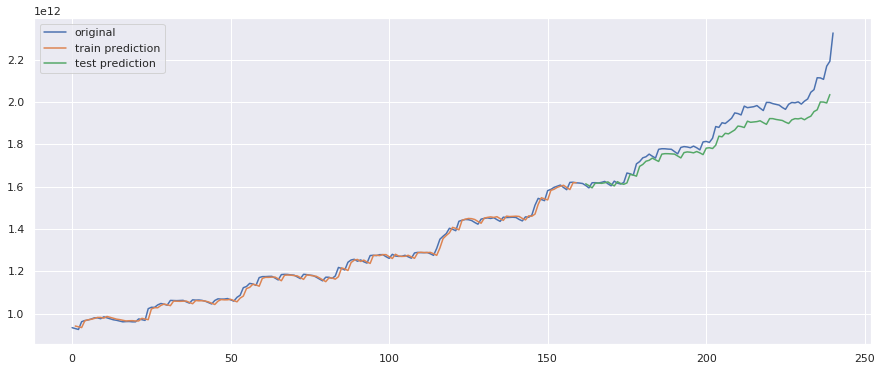

In [25]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.figure(1, figsize=(15, 6))
plt.plot(scaler.inverse_transform(dataset), label='original')
plt.plot(trainPredictPlot, label='train prediction')
plt.plot(testPredictPlot, label='test prediction')
plt.legend()
plt.show()

In [73]:
viz = pd.DataFrame(data={
    'date': df_input['buss_date'].values,
    'balance': np.concatenate((trainPredictPlot[:train_size,0], testPredictPlot[train_size:,0]))
})

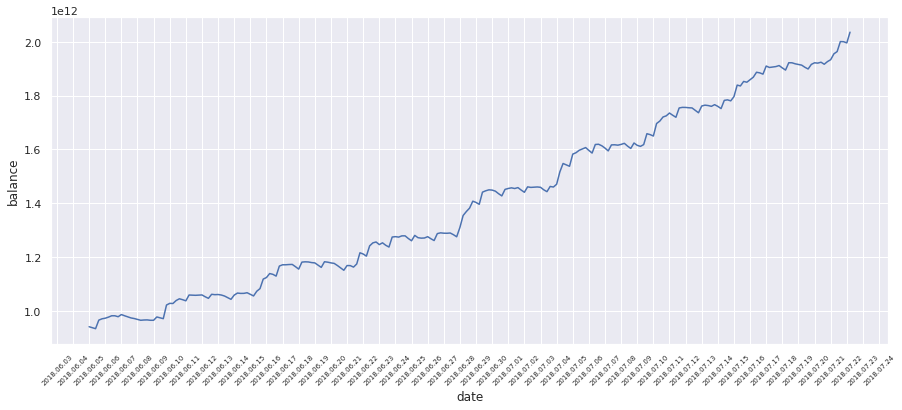

In [95]:


sns.set(rc={
    'figure.figsize': (15, 6),
    'xtick.labelsize': 7
})

ax = sns.lineplot(x="date", y="balance", data=viz)
plt.xticks(rotation=45)

loc = plticker.MultipleLocator(base=5.0)
ax.xaxis.set_major_locator(loc)

plt.show()